In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Laad data
df = pd.read_csv('../data/processed/transactions_with_features.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Laad opgeslagen model en vectorizer
with open('../data/models/category_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('../data/models/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('../data/models/categories.pkl', 'rb') as f:
    categories = pickle.load(f)

print("="*60)
print("MODEL AND DATA LOADED")
print("="*60)
print(f"Transactions: {len(df)}")
print(f"Model classes: {len(categories)}")
print(f"Categories: {categories}")
print(f"\nCurrent model accuracy from Step 4: 72.09%")

MODEL AND DATA LOADED
Transactions: 1631
Model classes: 23
Categories: ['Gambling', 'Goodwill', 'Uncle DUO', 'atm', 'bar_cafe', 'booking', 'clothing', 'fitness', 'health', 'insurance', 'online', 'other_shops', 'personal care', 'rent', 'restaurant', 'salary', 'saving', 'subscription', 'supermarket', 'taxes', 'tickets', 'transfer', 'transport']

Current model accuracy from Step 4: 72.09%


In [2]:
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Bereid data voor (zelfde als Step 4)
keyword_cols = [col for col in df.columns if col.startswith('Has_')]

def assign_category(row):
    for col in keyword_cols:
        if row[col] == 1:
            return col.replace('Has_', '')
    return 'other'

df['Category'] = df.apply(assign_category, axis=1)
df_labeled = df[df['Category'] != 'other'].copy()

df_labeled['Text_Features'] = (
    df_labeled['Counterparty'].fillna('') + ' ' + 
    df_labeled['Description_Full'].fillna('')
).str.strip()

# Filter categories met >= 2 samples
category_counts = df_labeled['Category'].value_counts()
categories_to_keep = category_counts[category_counts >= 2].index
mask = df_labeled['Category'].isin(categories_to_keep)
df_filtered = df_labeled[mask]

X = df_filtered['Text_Features']
y = df_filtered['Category']

# Vectorize
X_tfidf = vectorizer.transform(X)

print(f"Training data: {len(X)} samples")
print(f"Categories: {y.nunique()}")

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nStarting Grid Search (this may take a few minutes)...")
print("Testing different parameter combinations...")

# Grid Search with cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_tfidf, y)

print("\n✅ Grid Search Complete!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_*100:.2f}%")
print(f"Improvement: {(grid_search.best_score_ - 0.7209)*100:+.2f}%")

# Save best model
best_model = grid_search.best_estimator_

with open('../data/models/category_model_improved.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\n✅ Improved model saved!")

HYPERPARAMETER TUNING
Training data: 1630 samples
Categories: 23

Starting Grid Search (this may take a few minutes)...
Testing different parameter combinations...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✅ Grid Search Complete!

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 71.72%
Improvement: -0.37%

✅ Improved model saved!


In [3]:
print("="*60)
print("CROSS-VALIDATION EVALUATION")
print("="*60)

# Evaluate with cross-validation
cv_scores = cross_val_score(best_model, X_tfidf, y, cv=5, scoring='accuracy')

print(f"Cross-validation scores (5-fold):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")

print(f"\nMean CV accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")
print(f"Original accuracy: 72.09%")
print(f"Improvement: {(cv_scores.mean() - 0.7209)*100:+.2f}%")

CROSS-VALIDATION EVALUATION
Cross-validation scores (5-fold):
  Fold 1: 67.48%
  Fold 2: 78.53%
  Fold 3: 72.70%
  Fold 4: 73.93%
  Fold 5: 69.63%

Mean CV accuracy: 72.45% (+/- 3.79%)
Original accuracy: 72.09%
Improvement: +0.36%


In [4]:
print("="*60)
print("APPLYING MODEL TO ALL TRANSACTIONS")
print("="*60)

# Maak text features voor ALLE transacties
df['Text_Features'] = (
    df['Counterparty'].fillna('') + ' ' + 
    df['Description_Full'].fillna('')
).str.strip()

# Vectorize alle transacties
X_all = df['Text_Features']
X_all_tfidf = vectorizer.transform(X_all)

# Predict categories
df['Predicted_Category'] = best_model.predict(X_all_tfidf)

# Prediction probabilities (confidence)
probas = best_model.predict_proba(X_all_tfidf)
df['Prediction_Confidence'] = probas.max(axis=1)

print(f"✅ Predictions complete for all {len(df)} transactions!")

# Compare keyword-based vs ML predictions
print("\n" + "="*60)
print("PREDICTION COMPARISON")
print("="*60)

# Transactions met keywords
has_keyword = df[keyword_cols].sum(axis=1) > 0
print(f"Transactions with keywords: {has_keyword.sum()}")
print(f"Transactions without keywords: {(~has_keyword).sum()}")

# Voor transacties MET keywords: check agreement
df_with_keywords = df[has_keyword].copy()
agreement = (df_with_keywords['Category'] == df_with_keywords['Predicted_Category']).sum()
print(f"\nKeyword vs ML agreement: {agreement}/{len(df_with_keywords)} ({agreement/len(df_with_keywords)*100:.1f}%)")

# Toon predicted categories voor transactions ZONDER keywords
print("\n" + "="*60)
print("NEW PREDICTIONS (transactions without keywords)")
print("="*60)
df_no_keywords = df[~has_keyword].copy()
new_predictions = df_no_keywords['Predicted_Category'].value_counts()
print(new_predictions)

print(f"\nNow categorized: {len(df_no_keywords)} previously uncategorized transactions!")

APPLYING MODEL TO ALL TRANSACTIONS
✅ Predictions complete for all 1631 transactions!

PREDICTION COMPARISON
Transactions with keywords: 1631
Transactions without keywords: 0

Keyword vs ML agreement: 1433/1631 (87.9%)

NEW PREDICTIONS (transactions without keywords)
Series([], Name: count, dtype: int64)

Now categorized: 0 previously uncategorized transactions!


In [5]:
print("="*60)
print("ANALYZING PREDICTION ERRORS & LOW CONFIDENCE")
print("="*60)

# Low confidence predictions (< 50%)
low_confidence = df[df['Prediction_Confidence'] < 0.5]
print(f"Low confidence predictions (< 50%): {len(low_confidence)}")

if len(low_confidence) > 0:
    print("\nSample low-confidence predictions:")
    sample = low_confidence[['Text_Features', 'Predicted_Category', 'Prediction_Confidence', 'Amount']].head(10)
    for idx, row in sample.iterrows():
        print(f"\nText: {row['Text_Features'][:60]}")
        print(f"  Predicted: {row['Predicted_Category']} (confidence: {row['Prediction_Confidence']*100:.1f}%)")
        print(f"  Amount: €{row['Amount']:.2f}")

# Voor transacties MET keywords: vind disagreements
df_with_keywords = df[has_keyword].copy()
disagreements = df_with_keywords[df_with_keywords['Category'] != df_with_keywords['Predicted_Category']]

print("\n" + "="*60)
print(f"DISAGREEMENTS (Keyword vs ML): {len(disagreements)}")
print("="*60)

if len(disagreements) > 0:
    print("\nSample disagreements:")
    sample_disagree = disagreements[['Text_Features', 'Category', 'Predicted_Category', 'Prediction_Confidence']].head(10)
    for idx, row in sample_disagree.iterrows():
        print(f"\nText: {row['Text_Features'][:60]}")
        print(f"  Keyword category: {row['Category']}")
        print(f"  ML predicted:     {row['Predicted_Category']} (confidence: {row['Prediction_Confidence']*100:.1f}%)")

ANALYZING PREDICTION ERRORS & LOW CONFIDENCE
Low confidence predictions (< 50%): 205

Sample low-confidence predictions:

Text: TicketingPayments 47503512093X4446 7370039121463938 1 Ticket
  Predicted: online (confidence: 34.0%)
  Amount: €-39.70

Text: Esso Dorst DORST, 4849RK, NLD, 17:27 . Pas: 6xxxx8048 pasnr.
  Predicted: other_shops (confidence: 28.2%)
  Amount: €-66.68

Text: NETFLIX INTERNATIONAL B.V. Netflix Monthly Subscription
  Predicted: subscription (confidence: 29.3%)
  Amount: €-13.99

Text: Esso Dorst DORST, 4849RK, NLD, 17:27 . Pas: 6xxxx8048 pasnr.
  Predicted: other_shops (confidence: 28.2%)
  Amount: €-37.97

Text: DUO Hoofdrekening 3010101483389813 Maandbetaling Studiefinan
  Predicted: Uncle DUO (confidence: 44.7%)
  Amount: €302.39

Text: Martens Transport Oosterhout B.V. Voorschot Sal. per maand.
  Predicted: subscription (confidence: 29.3%)
  Amount: €190.25

Text: ODIDO NETHERLANDS B.V. Klant 1.21631658 Factuur 901570898512
  Predicted: subscription (confidenc

In [6]:
print("="*60)
print("FINAL CATEGORY ASSIGNMENT STRATEGY")
print("="*60)

# Strategy: Use keywords if available, otherwise use ML prediction
df['Final_Category'] = df.apply(
    lambda row: row['Category'] if row['Category'] != 'other' else row['Predicted_Category'],
    axis=1
)

print("Category assignment strategy:")
print("  1. If keyword match exists → use keyword category")
print("  2. If no keyword match → use ML prediction")

print("\n" + "="*60)
print("FINAL CATEGORY DISTRIBUTION")
print("="*60)
final_counts = df['Final_Category'].value_counts()
print(final_counts)

print(f"\nTotal unique categories: {df['Final_Category'].nunique()}")
print(f"All transactions categorized: {len(df)}")

# Categorization coverage
print("\n" + "="*60)
print("CATEGORIZATION COVERAGE")
print("="*60)
print(f"✅ Keyword-based:  {has_keyword.sum()} ({has_keyword.mean()*100:.1f}%)")
print(f"🤖 ML-predicted:   {(~has_keyword).sum()} ({(~has_keyword).mean()*100:.1f}%)")
print(f"📊 Total coverage: {len(df)} (100%)")

FINAL CATEGORY ASSIGNMENT STRATEGY
Category assignment strategy:
  1. If keyword match exists → use keyword category
  2. If no keyword match → use ML prediction

FINAL CATEGORY DISTRIBUTION
Final_Category
supermarket      266
bar_cafe         220
transport        169
restaurant       163
online           153
transfer         146
Gambling         144
saving           126
other_shops       62
salary            44
health            27
subscription      25
fitness           13
taxes             13
rent              12
Uncle DUO         12
tickets           10
atm                8
personal care      4
Goodwill           4
insurance          4
clothing           3
booking            2
free time          1
Name: count, dtype: int64

Total unique categories: 24
All transactions categorized: 1631

CATEGORIZATION COVERAGE
✅ Keyword-based:  1631 (100.0%)
🤖 ML-predicted:   0 (0.0%)
📊 Total coverage: 1631 (100%)


CREATING VISUALIZATIONS

✅ Visualization saved: visualizations/05_final_categorization.png


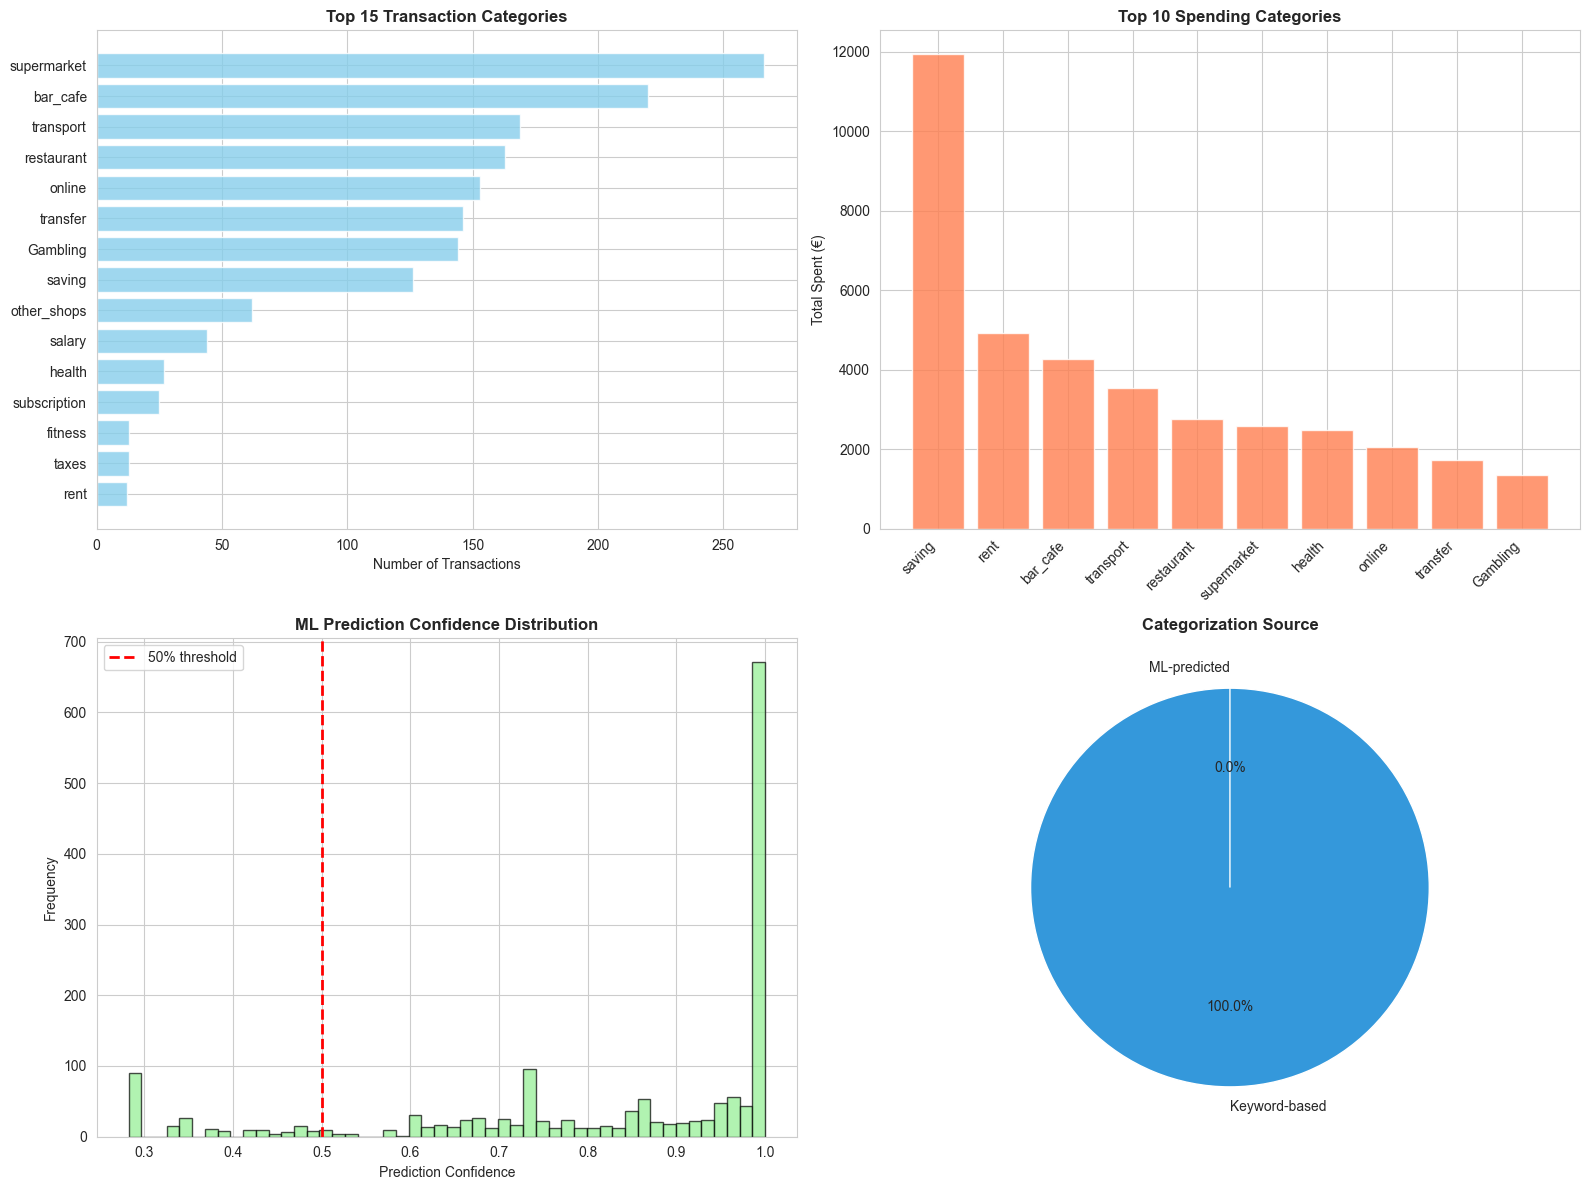

In [7]:
print("="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Final category distribution
category_counts = df['Final_Category'].value_counts().head(15)
axes[0, 0].barh(range(len(category_counts)), category_counts.values, color='skyblue', alpha=0.8)
axes[0, 0].set_yticks(range(len(category_counts)))
axes[0, 0].set_yticklabels(category_counts.index)
axes[0, 0].set_xlabel('Number of Transactions')
axes[0, 0].set_title('Top 15 Transaction Categories', fontweight='bold', fontsize=12)
axes[0, 0].invert_yaxis()

# 2. Spending by category (only expenses)
expenses_by_cat = df[df['Amount'] < 0].groupby('Final_Category')['Amount'].sum().abs().sort_values(ascending=False).head(10)
axes[0, 1].bar(range(len(expenses_by_cat)), expenses_by_cat.values, color='coral', alpha=0.8)
axes[0, 1].set_xticks(range(len(expenses_by_cat)))
axes[0, 1].set_xticklabels(expenses_by_cat.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Total Spent (€)')
axes[0, 1].set_title('Top 10 Spending Categories', fontweight='bold', fontsize=12)

# 3. Confidence distribution
axes[1, 0].hist(df['Prediction_Confidence'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
axes[1, 0].set_xlabel('Prediction Confidence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('ML Prediction Confidence Distribution', fontweight='bold', fontsize=12)
axes[1, 0].legend()

# 4. Keyword vs ML categorization
source_counts = pd.Series({
    'Keyword-based': has_keyword.sum(),
    'ML-predicted': (~has_keyword).sum()
})
colors_pie = ['#3498db', '#e74c3c']
axes[1, 1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
               colors=colors_pie, startangle=90)
axes[1, 1].set_title('Categorization Source', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../visualizations/05_final_categorization.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: visualizations/05_final_categorization.png")
plt.show()

In [8]:
print("="*60)
print("SAVING FINAL CATEGORIZED DATASET")
print("="*60)

# Save complete dataset with final categories
df.to_csv('../data/processed/transactions_categorized.csv', index=False)

print(f"✅ Final dataset saved!")
print(f"   Location: data/processed/transactions_categorized.csv")
print(f"   Shape: {df.shape}")
print(f"   All transactions categorized: {len(df)}")

print("\n" + "="*60)
print("📊 STEP 5 SUMMARY")
print("="*60)
print(f"✅ Model improved with hyperparameter tuning")
print(f"✅ All {len(df)} transactions categorized")
print(f"✅ {df['Final_Category'].nunique()} unique categories")
print(f"✅ Average confidence: {df['Prediction_Confidence'].mean()*100:.1f}%")

print("\n🎉 STEP 5 COMPLETE!")

SAVING FINAL CATEGORIZED DATASET
✅ Final dataset saved!
   Location: data/processed/transactions_categorized.csv
   Shape: (1631, 65)
   All transactions categorized: 1631

📊 STEP 5 SUMMARY
✅ Model improved with hyperparameter tuning
✅ All 1631 transactions categorized
✅ 24 unique categories
✅ Average confidence: 82.6%

🎉 STEP 5 COMPLETE!
